In [ ]:
# Inference fintuned scgpt

In [ ]:
# install scgpt
!pip install scgpt

# install wandb
!pip install wandb louvain faiss-cpu

# install scanpy (single cell analysis)
!pip install --upgrade scanpy

# install Google Drive Public File Downloader
!pip install -q -U gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s 

In [ ]:
import copy
import gc
import json
import os
import gdown
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
import anndata
from anndata import AnnData
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarn

Connect to google drive

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Step1 Specify hyper-parameter setup for cell-type annotation task

In [ ]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="scott",
    cls_type = 'cell', # cell or status
    do_train=True,
    load_model=model_dir,
    mask_ratio=0.0,
    epochs=10,
    n_bins=51,
    MVC=False, # Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-4,
    batch_size=8,
    # batch_size=32,
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = True, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

# use wandb

wandb.login(key='3cf5c965a123011d96ced5a14d0675c38dc2a8fe')

run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

# create save path
dataset_name = config.dataset_name
cls_type = config.cls_type
save_dir = os.path.join(cwd, "save")
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: j-mansoure77 (uhn). Use `wandb login --relogin` to force relogin


{'seed': 0, 'dataset_name': 'scott', 'cls_type': 'cell', 'do_train': True, 'load_model': '/content/scGPT_human', 'mask_ratio': 0.0, 'epochs': 10, 'n_bins': 51, 'MVC': False, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.0001, 'batch_size': 8, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': True, 'DSBN': False}


In [ ]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
max_seq_len = 3001
n_bins = config.n_bins

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = True  # celltype classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
ECS = config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product"
ecs_threshold = config.ecs_thres
dab_weight = config.dab_weight

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True

# %% validate settings
assert input_style in ["normed_raw", "log1p", "binned"]
assert output_style in ["normed_raw", "log1p", "binned"]
assert input_emb_style in ["category", "continuous", "scaling"]
if input_style == "binned":
    if input_emb_style == "scaling":
        raise ValueError("input_emb_style `scaling` is not supported for binned input.")
elif input_style == "log1p" or input_style == "normed_raw":
    if input_emb_style == "category":
        raise ValueError(
            "input_emb_style `category` is not supported for log1p or normed_raw input."
        )

if input_emb_style == "category":
    mask_value = n_bins + 1
    pad_value = n_bins  # for padding gene expr values
    n_input_bins = n_bins + 2
else:
    mask_value = -1
    pad_value = -2
    n_input_bins = n_bins

if ADV and DAB:
    raise ValueError("ADV and DAB cannot be both True.")
DAB_separate_optim = True if DAB > 1 else False

Step 2: Load and pre-process data

In [ ]:
# load Yeg data and split train and test

if dataset_name == "yeg":

    data_dir = '/content/drive/My Drive/scgpt/data/Yeg/'
    meta = pd.read_csv(data_dir + 'GSE166992_metadata_metedata_cell_coordinate_tsne.csv')
    adata = sc.read_text(data_dir + 'GSE166992_rawdata_raw_counts.txt.gz').T
    adata.obs = meta

    # creat batch id to separate train and test
    # train data has batch_id 0
    adata.obs["batch_id"]  = 0

    # split train ans test
    train_id = ['GSM5090446', 'GSM5090448', 'GSM5090447', 'GSM5090449'] # 2 healthy, 2 covid
    test_id = ['GSM5090454', 'GSM5090453', 'GSM5090451']  # 1 healthy, 2 covid

    # test data has batch_id 1
    adata.obs.loc[adata.obs['orig.ident'].isin(test_id), "batch_id"] = 1

    # change label columns name to celltype
    # subtype is different cell types
    if cls_type == 'cell':
      adata.obs.rename(columns={"Type":"celltype"}, inplace=True)
    elif cls_type == 'status':
    # if it is classification of status
      adata.obs.rename(columns={"Status":"celltype"}, inplace=True)

    #adata.obs["celltype"] = adata.obs["Factor Value[inferred cell type - authors labels]"].astype("category")
    #adata_test.obs["celltype"] = adata_test.obs["Factor Value[inferred cell type - authors labels]"].astype("category")

    data_is_raw = True
    filter_gene_by_counts = False
    adata.var["gene_name"] = adata.var.index

    print('data', adata.shape)


In [ ]:
# load scott data and split train and test

if dataset_name == "scott":

    data_dir = '/content/drive/My Drive/scgpt/data/Scott/'
    meta = pd.read_csv(data_dir + 'GSE155673_metadata_metedata_cell_coordinate_tsne.csv')
    adata = sc.read_text(data_dir + 'GSE155673_rawdata_raw_counts.txt.gz').T
    adata.obs = meta

    # creat batch id to separate train and test
    # train data has batch_id 0
    adata.obs["batch_id"]  = 0

    # split train ans test
    ids = adata.obs.groupby('orig.ident')['Status'].unique().index.values
    train_id = np.append(ids[:7], ids[11])
    test_id = ids[7:11]

    # test data has batch_id 1
    adata.obs.loc[adata.obs['orig.ident'].isin(test_id), "batch_id"] = 1

    # test data 1
    # one random patient is test
    # p = adata.obs['orig.ident'].unique()
    # testp = p[np.random.randint(1, len(p))]
    # adata.obs.loc[adata.obs['orig.ident']==testp, "batch_id"] = 1

    # change label columns name to celltype
    if cls_type == 'cell':
      adata.obs.rename(columns={"Type":"celltype"}, inplace=True)
    elif cls_type == 'status':
    # if it is classification of status
      adata.obs.rename(columns={"Status":"celltype"}, inplace=True)

    #adata.obs["celltype"] = adata.obs["Factor Value[inferred cell type - authors labels]"].astype("category")
    #adata_test.obs["celltype"] = adata_test.obs["Factor Value[inferred cell type - authors labels]"].astype("category")

    data_is_raw = True
    filter_gene_by_counts = False
    adata.var["gene_name"] = adata.var.index

    print('data', adata.shape)

In [ ]:

# categorize batch and cell type
batch_id_labels = adata.obs["batch_id"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata.obs["celltype"].unique()
num_types = len(np.unique(celltype_id_labels))
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))
adata.obs["celltype_id"] = celltype_id_labels

if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )

    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

scGPT - INFO - match 16373/20370 genes in vocabulary of size 36574.
scGPT - INFO - Resume model from /content/scGPT_human/best_model.pt, the model args will override the config /content/scGPT_human/args.json.


In [ ]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)


adata_test = adata[adata.obs["batch_id"] == 1]
adata = adata[adata.obs["batch_id"] == 0]

preprocessor(adata, batch_key=None)
preprocessor(adata_test, batch_key=None)

print('train', adata.shape)
print('test', adata_test.shape)

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


In [ ]:
input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_normed",
    "binned": "X_binned",
}[input_style]
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype_id"].tolist()  # make sure count from 0
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)

if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=include_zero_gene,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 22895, 
	 feature length: 3001
scGPT - INFO - valid set number of samples: 2544, 
	 feature length: 3001


In [ ]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    tensor_celltype_labels_train = torch.from_numpy(train_celltype_labels).long()
    tensor_celltype_labels_valid = torch.from_numpy(valid_celltype_labels).long()

    if sort_seq_batch:  # TODO: update to random pick seq source in each traning batch
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]
        tensor_celltype_labels_train = tensor_celltype_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]
        tensor_celltype_labels_valid = tensor_celltype_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
        "celltype_labels": tensor_celltype_labels_train,
    }

    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
        "celltype_labels": tensor_celltype_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)


    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

Step 3: Load scGPT model for inference

In [ ]:
# current path
cwd = os.getcwd()

# load model from Drive
model_dir = os.path.join(cwd, "scGPT")
drive_dir = '/content/drive/My Drive/scgpt/scgpt_blood_finetuned/'

if not os.path.exists(model_dir):
  !mkdir -p $model_dir
  shutil.copy(drive_dir+'args.json', model_dir)
  shutil.copy(drive_dir+'best_model.pt', model_dir)
  shutil.copy(drive_dir+'vocab.json', model_dir)

# load primary scgpt model
# model_dir = os.path.join(cwd, "scGPT")
# if not os.path.exists(model_dir):
#     !mkdir -p $model_dir

#     gdown.download_folder("https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",
#                           output=model_dir,)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    cell_emb_style=cell_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=config.pre_norm,
)


if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)
wandb.watch(model)

if ADV:
    discriminator = AdversarialDiscriminator(
        d_model=embsize,
        n_cls=num_batch_types,
    ).to(device)

scGPT - INFO - Loading all model params from /content/scGPT_human/best_model.pt


In [ ]:
# loss

criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, schedule_interval, gamma=config.schedule_ratio
)
if DAB_separate_optim:
    optimizer_dab = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler_dab = torch.optim.lr_scheduler.StepLR(
        optimizer_dab, schedule_interval, gamma=config.schedule_ratio
    )
if ADV:
    criterion_adv = nn.CrossEntropyLoss()  # consider using label smoothing
    optimizer_E = torch.optim.Adam(model.parameters(), lr=lr_ADV)
    scheduler_E = torch.optim.lr_scheduler.StepLR(
        optimizer_E, schedule_interval, gamma=config.schedule_ratio
    )
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_ADV)
    scheduler_D = torch.optim.lr_scheduler.StepLR(
        optimizer_D, schedule_interval, gamma=config.schedule_ratio
    )

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [ ]:
def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    predictions = []
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)
            celltype_labels = batch_data["celltype_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                    CLS=CLS,  # evaluation does not need CLS or CCE
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=do_sample_in_train,
                    #generative_training = False,
                )

                output_values = output_dict["cls_output"]
                loss = criterion_cls(output_values, celltype_labels)

                if DAB:
                    loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            accuracy = (output_values.argmax(1) == celltype_labels).sum().item()
            total_error += (1 - accuracy / len(input_gene_ids)) * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids) if DAB else 0.0
            total_num += len(input_gene_ids)
            preds = output_values.argmax(1).cpu().numpy()
            predictions.append(preds)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/err": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + dab_weight * total_dab) / total_num,
            #"epoch": epoch,
        },
    )

    if return_raw:
        return np.concatenate(predictions, axis=0)

    return total_loss / total_num, total_error / total_num

In [ ]:
# %% inference
def test(model: nn.Module, adata: DataLoader) -> float:
    all_counts = (
        adata.layers[input_layer_key].A
        if issparse(adata.layers[input_layer_key])
        else adata.layers[input_layer_key]
    )

    celltypes_labels = adata.obs["celltype_id"].tolist()  # make sure count from 0
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    tokenized_test = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=include_zero_gene,
    )

    input_values_test = random_mask_value(
        tokenized_test["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )

    test_data_pt = {
        "gene_ids": tokenized_test["genes"],
        "values": input_values_test,
        "target_values": tokenized_test["values"],
        "batch_labels": torch.from_numpy(batch_ids).long(),
        "celltype_labels": torch.from_numpy(celltypes_labels).long(),
    }

    test_loader = DataLoader(
        dataset=SeqDataset(test_data_pt),
        batch_size=eval_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=min(len(os.sched_getaffinity(0)), eval_batch_size // 2),
        pin_memory=True,
    )

    model.eval()
    predictions = evaluate(
        model,
        loader=test_loader,
        return_raw=True,
    )

    # compute accuracy, precision, recall, f1
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    accuracy = accuracy_score(celltypes_labels, predictions)
    precision = precision_score(celltypes_labels, predictions, average="macro")
    recall = recall_score(celltypes_labels, predictions, average="macro")
    macro_f1 = f1_score(celltypes_labels, predictions, average="macro")
    #auc = roc_auc_score(celltypes_labels, predictions)

    logger.info(
        f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, "
        f"Macro F1: {macro_f1:.3f}"
    )

    results = {
        "test/accuracy": accuracy,
        "test/precision": precision,
        "test/recall": recall,
        "test/macro_f1": macro_f1,
        #"test/auc": auc,
    }

    return predictions, celltypes_labels, results

(19312, 16373)
scGPT - INFO - Accuracy: 0.806, Precision: 0.584, Recall: 0.535, Macro F1: 0.509
         Falling back to preprocessing with `sc.pp.pca` and default params.


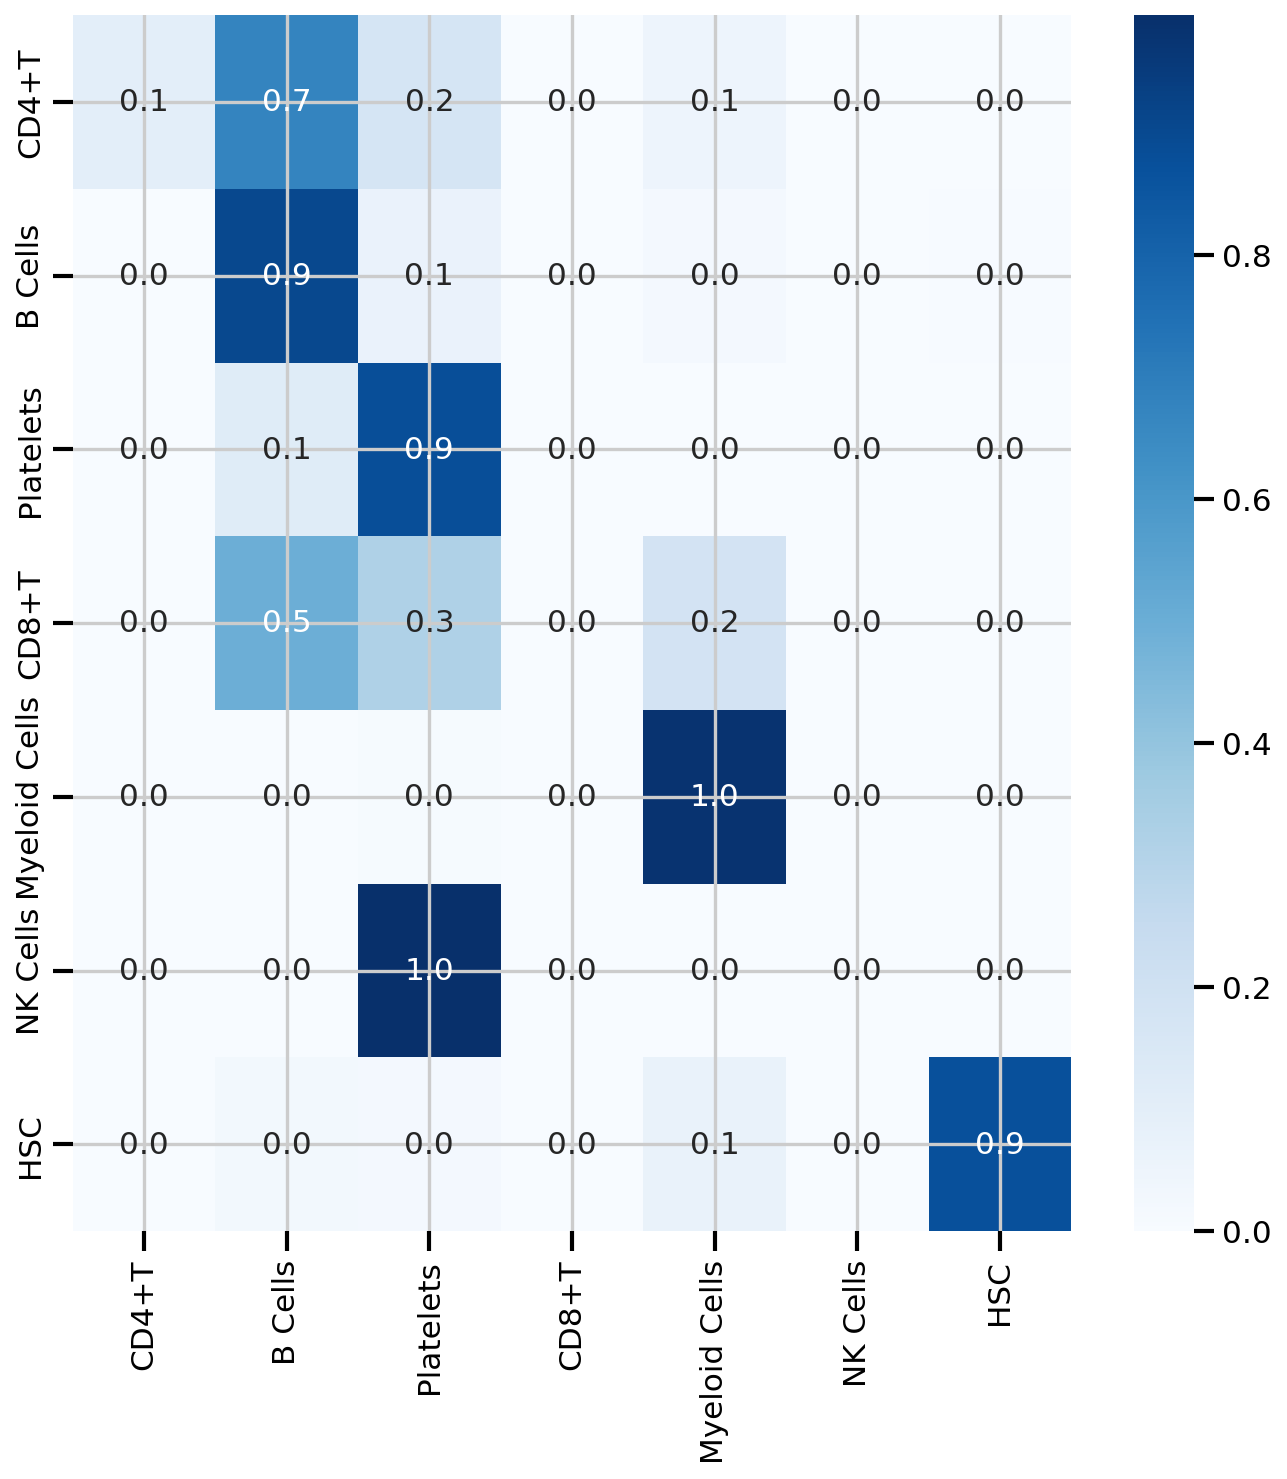

<Figure size 1200x800 with 0 Axes>

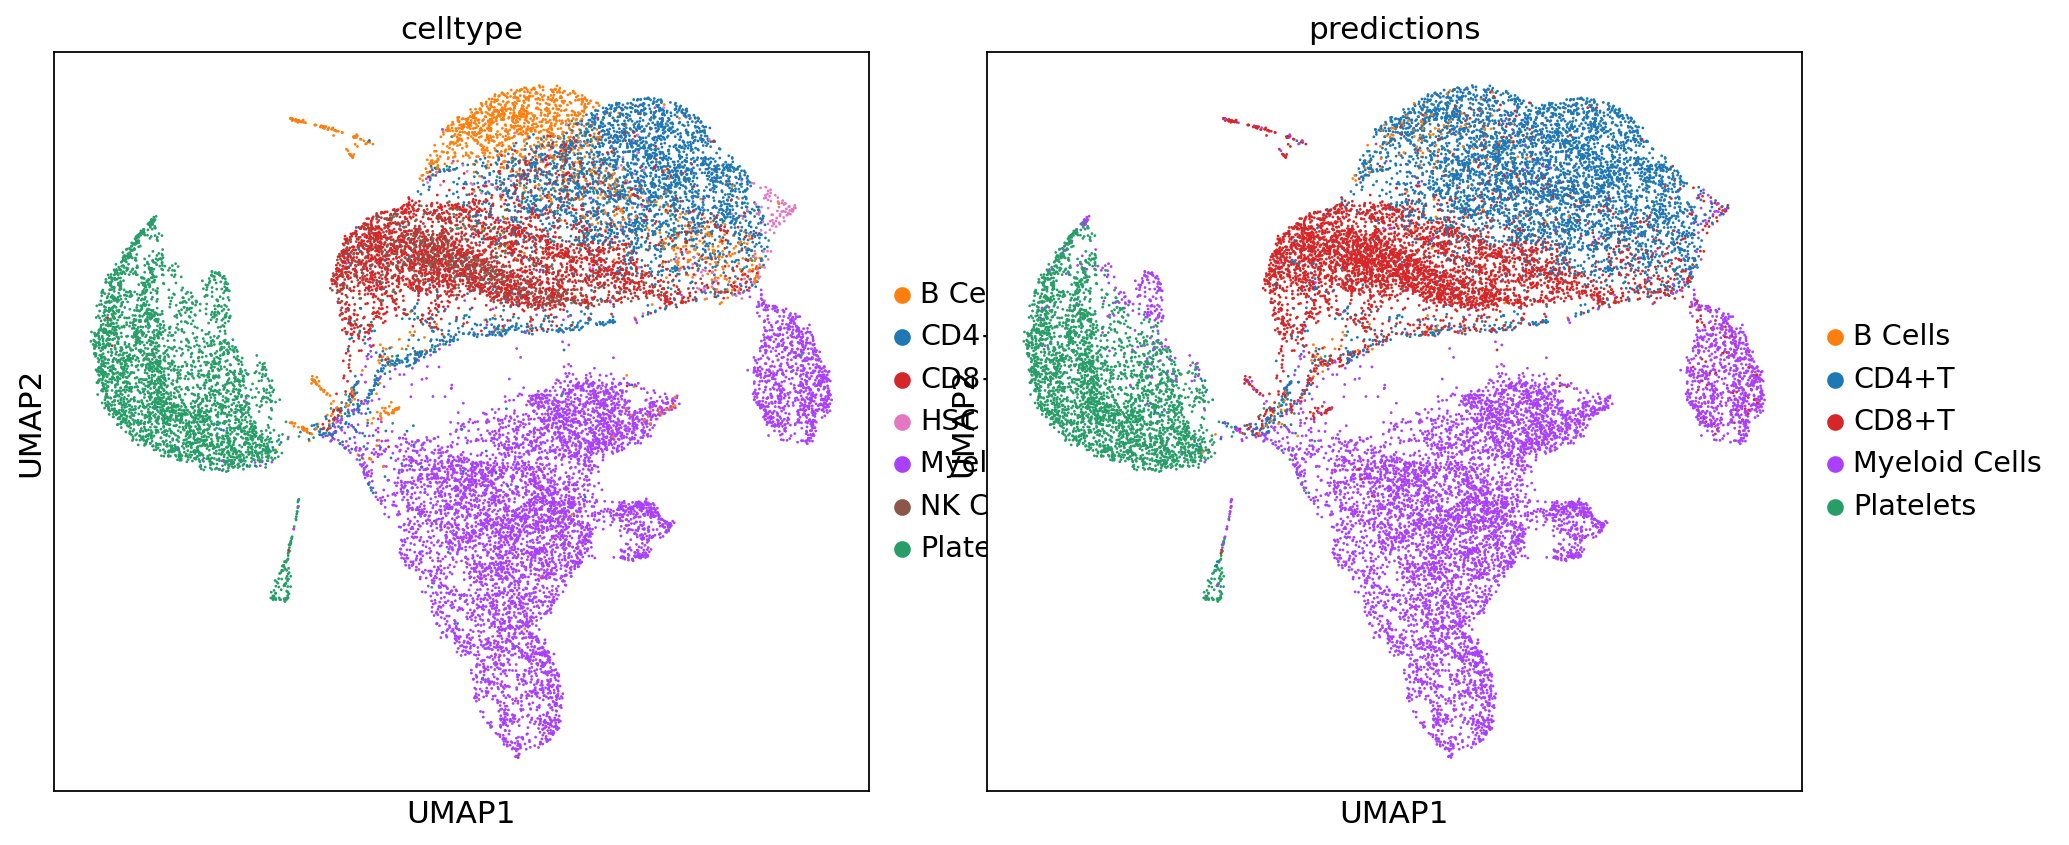

In [ ]:
# evaluate all test data

print(adata_test.shape)

predictions, labels, results = test(model, adata_test)

# confusion matrix
cm = confusion_matrix(labels, predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=celltypes[:cm.shape[0]], columns=celltypes[:cm.shape[1]])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

plt.savefig(save_dir / "confusion_test.svg", format='svg')

adata_test.obs["predictions"] = [id2type[p] for p in predictions]

palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette_ = {c: palette_[i] for i, c in enumerate(celltypes)}

# prediction umap
sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test)
plt.figure(figsize=(15, 10))
sc.pl.umap(
        adata_test,
        color=["celltype", "predictions"],
        palette=palette_,
        show=False,
    )

plt.subplots_adjust(hspace=5)

plt.savefig(save_dir / "umap_test.svg", format='svg')